<h1><center>Daily Covid-19 Deaths</center></h1>
From <a href = "https://www.england.nhs.uk/statistics/statistical-work-areas/covid-19-daily-deaths/">NHS page</a> on Covid-19 deaths.

In [1]:
import requests, bs4, os
import numpy as np
import requests
import pandas as pd


## Find spreadsheet link

In [2]:
root_url = "https://www.england.nhs.uk/statistics/statistical-work-areas/covid-19-daily-deaths/"
res = requests.get(root_url)
soup = bs4.BeautifulSoup(res.content)

linkElems = soup.select("a")

for elem in linkElems:
    url = elem.get('href')
    if "COVID-19-total-announced-deaths" in url and not "weekly" in url:
        link = url

print("Link:", link)

Link: https://www.england.nhs.uk/statistics/wp-content/uploads/sites/2/2020/11/COVID-19-total-announced-deaths-23-November-2020.xlsx


## Load Spreadsheet

In [3]:
resp = requests.get(link)

# Store the data in a temporary file
tempfile = open('tempfile.xls', 'wb')
tempfile.write(resp.content)
tempfile.close()

sheet = pd.read_excel('tempfile.xls', sheet_name=5, skiprows=15)

# get names
names = np.delete(sheet["Name"].values,1) # (deleting empty space)

#get dates
dates = sheet.columns.values[6:-4]

deaths = np.delete(sheet.values[:,6:-4], 1, 0) # (deleting empty row)
os.remove("tempfile.xls")
print("Spreadsheet loaded.")

Spreadsheet loaded.


## Combine Bedford and Luton
Since the two trusts have actually merged

In [4]:
bedford_name = "BEDFORD HOSPITAL NHS TRUST"
luton_name = "LUTON AND DUNSTABLE UNIVERSITY HOSPITAL NHS FOUNDATION TRUST"

bedfordshire_name = "Bedfordshire Hospitals NHS Foundation Trust"

bedford_index = np.where(names == bedford_name)[0][0]
luton_index = np.where(names == luton_name)[0][0]

# get Bedfordshire trust total deaths
bedford_deaths = deaths[bedford_index, :]
luton_deaths = deaths[luton_index, :]
befordshire_deaths = bedford_deaths + luton_deaths

# Replace Bedford with Bedfordshire
deaths[bedford_index,:] = befordshire_deaths
names[bedford_index] = bedfordshire_name

# delete Luton entries
deaths = np.delete(deaths, luton_index, 0)
names = np.delete(names, luton_index)
print("Bedford and Luton combined.")

Bedford and Luton combined.


## Merge Mid and South Essex Trusts

In [5]:
name1="Basildon and Thurrock University Hospitals NHS Foundation Trust"
name2="Mid Essex Hospital Services NHS Trust"
name3="Southend University Hospital NHS Foundation Trust"
new_name = "Mid and South Essex NHS Foundation Trust"

index1 = np.where(names == name1.upper())[0][0]
index2 = np.where(names == name2.upper())[0][0]
index3 = np.where(names == name3.upper())[0][0]

essex_deaths = deaths[index1, :]+deaths[index2, :]+deaths[index3, :]

# replace first trust with combined
names[index1] = new_name
deaths[index1,:] = essex_deaths

# delete old trusts
deaths = np.delete(deaths, index2, 0)
names = np.delete(names, index2)
deaths = np.delete(deaths, index3, 0)
names = np.delete(names, index3)
print("Essex trusts combined.")

Essex trusts combined.


## Check plot

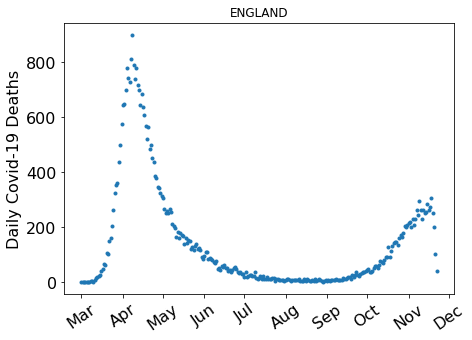

In [6]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib

matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rc('font', size=16)

index = 0

fig = plt.figure(figsize = (7,5))
ax = fig.add_subplot(111)
ax.set_title(names[index], size = 12)

ax.plot(dates, deaths[index,:], ".")
ax.set_ylabel("Daily Covid-19 Deaths")
ax.xaxis.set_tick_params(rotation=35)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax.set_ylabel("Daily Covid-19 Deaths")
plt.show()

## Save data

In [7]:
np.save("covid_deaths.npy", [names, dates, deaths])